<a href="https://colab.research.google.com/github/ovbystrova/Interference/blob/master/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://github.com/ovbystrova/Interference/raw/master/data/original_texts.csv

--2020-03-17 22:05:56--  https://github.com/ovbystrova/Interference/raw/master/data/original_texts.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ovbystrova/Interference/master/data/original_texts.csv [following]
--2020-03-17 22:06:02--  https://raw.githubusercontent.com/ovbystrova/Interference/master/data/original_texts.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18891291 (18M) [text/plain]
Saving to: ‘original_texts.csv’

original_texts.csv  100%[===================>]  18.02M  --.-KB/s    in 0.08s   

2020-03-17 22:06:03 (212 MB/s) - ‘original_texts.csv’ saved [18891291/18891291]



In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy import stats
from collections import Counter
from tqdm import tqdm

## Dataset

In [0]:
df = pd.read_csv('original_texts.csv', index_col='id')

In [4]:
df.head()

,native,language_background,title,text,date1,date2,level,annotated,checked
id,,,,,,,,,
1,eng,HL,"expository (non-timed, paragraph, Environmenta...",Загрязнение тяжелыми металлами Дальнегорского...,2009.0,2010.0,AM,1,1
2,NaN,NaN,–,Многие жители России пишут письма президенту М...,2000.0,2013.0,NaN,1,1
3,eng,HL,"business correspondence (non-timed, paragraph,...",Директору магазина « Адидас» М. И. Васильченк...,2009.0,2010.0,AM,1,1
4,eng,FL,"definition (non-timed, sentences, Russian in t...",&lt; Что такое аннотация?&gt;. Что такое анно...,2011.0,2012.0,IH,1,1
5,eng,FL,"summary (non-timed, paragraph, Capstone)","Вывод. Спасибо, ребята, за хорошие ответы. Я ...",2012.0,2013.0,AM,1,1


Drop useless for our task columns and NaNs

In [0]:
df = df.drop(['title', 'date1', 'date2', 'level', 'annotated', 'checked'], axis=1)

In [0]:
df = df.dropna()

In [0]:
df['text'] = df.text.apply(lambda x: re.sub('\&[lg]t;', '', x))

In [8]:
df.head()

,native,language_background,text
id,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...


There is a class imbalance

In [9]:
df['native'].value_counts()

eng    3145
jap    1571
fin    1231
fr      495
kaz     494
ger     283
kor     197
swe     178
ita     115
taj      30
nor      28
chi      24
ser      19
dut      18
est       2
Name: native, dtype: int64

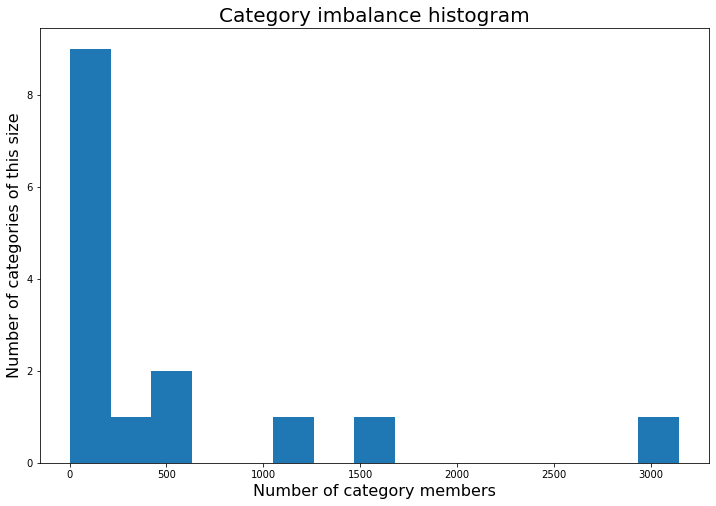

In [34]:
plt.figure(figsize=(12, 8))
plt.hist(df['native'].value_counts(), bins=len(df['native'].value_counts()))
plt.title('Category imbalance histogram', fontsize=20)
plt.xlabel('Number of category members', fontsize=16)
plt.ylabel('Number of categories of this size', fontsize=16);

In [10]:
df['language_background'].value_counts()

FL    5396
HL    2434
Name: language_background, dtype: int64

## Word n-grams + truncation

### Choose word number limit for truncation
As we cannot really truncate by the length of the samllest text which is 1 word or close

---



In [29]:
df['len'] = df['text'].apply(lambda x: len(x.split()))
df.head()

,native,language_background,text,len
id,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,368
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,186
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,29
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385
6,eng,FL,Записи. Первая проблема- что производить? втор...,278


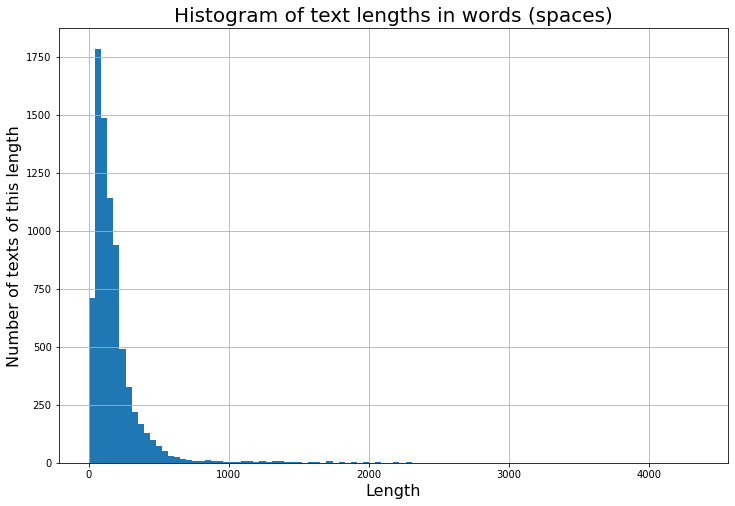

In [33]:
plt.figure(figsize=(12, 8))
df['len'].hist(bins=100)
plt.title('Histogram of text lengths in words (spaces)', fontsize=20)
plt.xlabel('Length', fontsize=16)
plt.ylabel('Number of texts of this length', fontsize=16);

In [35]:
np.mean(list(df['len']))

179.23575989782887

In [36]:
stats.mode(list(df['len']))

ModeResult(mode=array([64]), count=array([54]))

How many members are we keeping and loosing if we cut by mode

In [37]:
len(df[df['len'] >= 64])

6300

In [38]:
len(df[df['len'] < 64])

1530

### Tokenize texts

In [0]:
df['word_tokens'] = df['text'].apply(lambda x: re.findall('\w+', x.lower()))

In [40]:
df.head()

,native,language_background,text,len,word_tokens
id,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,368,"[загрязнение, тяжелыми, металлами, дальнегорск..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,186,"[директору, магазина, адидас, м, и, васильченк..."
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,29,"[что, такое, аннотация, что, такое, аннотация,..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в..."


### Truncate texts by words

In [0]:
df['words_truncated'] = df.word_tokens.apply(lambda x: [x[i] for i in range(len(x)) if i <= 64])

In [42]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated
id,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,368,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,186,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк..."
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,29,"[что, такое, аннотация, что, такое, аннотация,...","[что, такое, аннотация, что, такое, аннотация,..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в..."


### Universal n-gram functions for the dataset

In [0]:
def collect_ngrams(token_list, n, char=True):
  """
  creates an n-gram list from tokens

  :param token_list: iterable of str, tokens
  :param n: int, length of n-gram
  :param char: bool, whether to create word n-grams or character n-grams,
               optional, default True
  :return: list of str, n-grams
  """
  ngram_list = []
  for i in range(len(token_list)):
    ngram = token_list[i]
    if i + n > len(token_list):
      break
    else:
      for it in range(1, n):
        if char == True:
          ngram = ngram + token_list[i + it]
        else:
          ngram = ngram + ' ' + token_list[i + it]
    ngram_list.append(ngram)
  return ngram_list


In [0]:
def make_counter(commons):
  """
  creates a counter from a list of tuples key:count

  :param commons: list of tuple (int or str: int or float), (key: count)
  :return: collections.Counter of the same items
  """
  return Counter({x[0]: x[1] for x in commons})

In [0]:
def freq_ngrams(token_list, n, n_freq, char=True):
  """
  Counter of n-grams from tokens above a certain frequency

  :param token_list: iterable of str, tokens
  :param n: int, length of n-gram
  :param n_freq: int, threshold frequency
  :param char: bool, whether to create word n-grams or character n-grams,
               optional, default True
  :return: collections.Counter of n-grams above a certain frequency
  """
  ngram_list = collect_ngrams(token_list, n, char=char)
  return make_counter(Counter(ngram_list).most_common(n_freq))

### Make frequent word bi- and trigram lists

In [0]:
df['word_unigrams'] = df.words_truncated.apply(lambda x: make_counter(Counter(x).most_common(3000)))

In [0]:
df['word_bigrams'] = df.words_truncated.apply(lambda x: freq_ngrams(x, 2, 3000, char=False))

In [0]:
df['word_trigrams'] = df.words_truncated.apply(lambda x: freq_ngrams(x, 3, 3000, char=False))

In [73]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated,word_unigrams,word_bigrams,word_trigrams,len_sym,char_truncated
id,,,,,,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,368,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск...","{'загрязнение': 2, 'тяжелыми': 2, 'металлами':...","{'тяжелыми металлами': 2, 'пос рудная': 2, 'ру...","{'пос рудная пристань': 2, 'загрязнение тяжелы...",2805,Загрязнение тяжелыми металлами Дальнегорского...
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,186,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк...","{'магазина': 2, 'адидас': 2, 'и': 2, 'г': 2, '...","{'магазина адидас': 2, 'г владимир': 2, 'влади...","{'г владимир ул': 2, 'директору магазина адида...",1375,Директору магазина « Адидас» М. И. Васильченк...
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,29,"[что, такое, аннотация, что, такое, аннотация,...","[что, такое, аннотация, что, такое, аннотация,...","{'что': 2, 'такое': 2, 'аннотация': 2, 'как': ...","{'что такое': 2, 'такое аннотация': 2, 'аннота...","{'что такое аннотация': 2, 'такое аннотация чт...",202,Что такое аннотация?. Что такое аннотация ( ...
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ...","{'все': 3, 'и': 3, 'что': 3, 'во': 2, 'согласн...","{'согласны что': 2, 'вывод спасибо': 1, 'спаси...","{'вывод спасибо ребята': 1, 'спасибо ребята за...",2472,"Вывод. Спасибо, ребята, за хорошие ответы. Я ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в...","{'и': 5, 'производить': 3, 'первая': 2, 'пробл...","{'записи первая': 1, 'первая проблема': 1, 'пр...","{'записи первая проблема': 1, 'первая проблема...",2289,Записи. Первая проблема- что производить? втор...


## Character n-grams + truncation

### Choose character number limit
As we cannot really truncate by the length of the samllest text which is 1 word or close

---

In [0]:
df['len_sym'] = df.text.apply(lambda x: len(x))

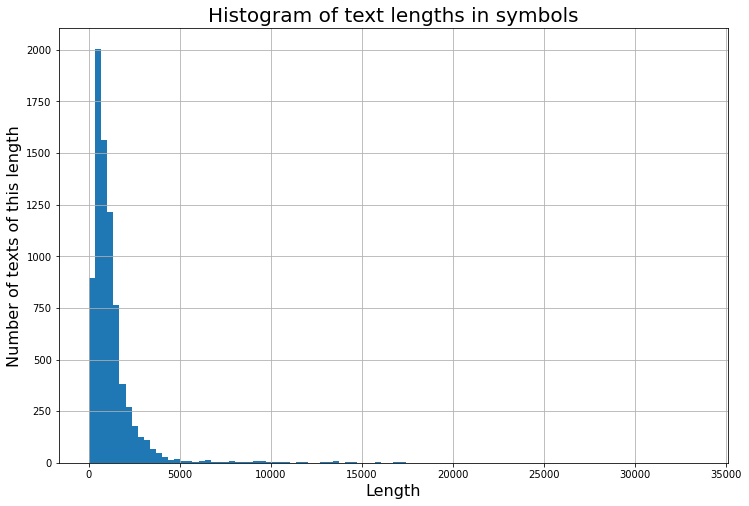

In [58]:
plt.figure(figsize=(12, 8))
df['len_sym'].hist(bins=100)
plt.title('Histogram of text lengths in symbols', fontsize=20)
plt.xlabel('Length', fontsize=16)
plt.ylabel('Number of texts of this length', fontsize=16);

How many members are we keeping and loosing if we cut by mode

In [55]:
stats.mode(list(df['len_sym']))

ModeResult(mode=array([390]), count=array([16]))

In [56]:
len(df[df.len_sym >= 630])

5199

In [59]:
len(df[df.len_sym < 630])

2631

### Truncate texts by characters

In [0]:
df['char_truncated'] = df.text.apply(lambda x: x[:630])

### Make frequent n-gram samples, 3 <= n <= 10

In [0]:
try:
  for instance in tqdm._instances:
    tqdm.decr_(instance)
except AttributeError:
  pass

In [75]:
for i in tqdm(range(3, 11)):
  col_name = f'character {i}-grams'
  df[col_name] = df.char_truncated.apply(lambda x: freq_ngrams(x, i, 3000, char=True))

100%|██████████| 8/8 [00:57<00:00,  8.07s/it]


In [76]:
df.head()

,native,language_background,text,len,word_tokens,words_truncated,word_unigrams,word_bigrams,word_trigrams,len_sym,char_truncated,character 3-grams,character 4-grams,character 5-grams,character 6-grams,character 7-grams,character 8-grams,character 9-grams,character 10-grams
id,,,,,,,,,,,,,,,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,368,"[загрязнение, тяжелыми, металлами, дальнегорск...","[загрязнение, тяжелыми, металлами, дальнегорск...","{'загрязнение': 2, 'тяжелыми': 2, 'металлами':...","{'тяжелыми металлами': 2, 'пос рудная': 2, 'ру...","{'пос рудная пристань': 2, 'загрязнение тяжелы...",2805,Загрязнение тяжелыми металлами Дальнегорского...,"{'ых ': 5, 'агр': 4, 'гря': 4, 'ряз': 4, 'язн'...","{'агря': 4, 'гряз': 4, 'рязн': 4, 'язне': 4, '...","{'агряз': 4, 'грязн': 4, 'рязне': 4, 'язнен': ...","{'агрязн': 4, 'грязне': 4, 'рязнен': 4, 'язнен...","{'агрязне': 4, 'грязнен': 4, 'рязнени': 3, 'вл...","{'агрязнен': 4, 'грязнени': 3, 'вляется ': 3, ...","{'агрязнени': 3, ' загрязне': 3, 'загрязнен': ...","{' загрязнен': 3, 'агрязнение': 2, 'грязнение ..."
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,186,"[директору, магазина, адидас, м, и, васильченк...","[директору, магазина, адидас, м, и, васильченк...","{'магазина': 2, 'адидас': 2, 'и': 2, 'г': 2, '...","{'магазина адидас': 2, 'г владимир': 2, 'влади...","{'г владимир ул': 2, 'директору магазина адида...",1375,Директору магазина « Адидас» М. И. Васильченк...,"{'го ': 7, 'на ': 5, 'ина': 4, '. В': 4, 'л. '...","{'ого ': 4, 'ина ': 3, 'его ': 3, 'ения': 3, '...","{'ного ': 3, 'ать н': 3, ' Дире': 2, 'Дирек': ...","{' Дирек': 2, 'Директ': 2, 'иректо': 2, 'ректо...","{' Директ': 2, 'Директо': 2, 'иректор': 2, 'ре...","{' Директо': 2, 'Директор': 2, 'иректору': 2, ...","{' Директор': 2, 'Директору': 2, 'иректору ': ...","{' Директору': 2, 'Директору ': 2, ' магазина ..."
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,29,"[что, такое, аннотация, что, такое, аннотация,...","[что, такое, аннотация, что, такое, аннотация,...","{'что': 2, 'такое': 2, 'аннотация': 2, 'как': ...","{'что такое': 2, 'такое аннотация': 2, 'аннота...","{'что такое аннотация': 2, 'такое аннотация чт...",202,Что такое аннотация?. Что такое аннотация ( ...,"{'то ': 3, ' Чт': 2, 'Что': 2, 'о т': 2, ' та'...","{' Что': 2, 'Что ': 2, 'то т': 2, 'о та': 2, '...","{' Что ': 2, 'Что т': 2, 'то та': 2, 'о так': ...","{' Что т': 2, 'Что та': 2, 'то так': 2, 'о так...","{' Что та': 2, 'Что так': 2, 'то тако': 2, 'о ...","{' Что так': 2, 'Что тако': 2, 'то такое': 2, ...","{' Что тако': 2, 'Что такое': 2, 'то такое ': ...","{' Что такое': 2, 'Что такое ': 2, 'то такое а..."
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",385,"[вывод, спасибо, ребята, за, хорошие, ответы, ...","[вывод, спасибо, ребята, за, хорошие, ответы, ...","{'все': 3, 'и': 3, 'что': 3, 'во': 2, 'согласн...","{'согласны что': 2, 'вывод спасибо': 1, 'спаси...","{'вывод спасибо ребята': 1, 'спасибо ребята за...",2472,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...","{'то ': 6, ' от': 5, ' по': 5, ' и ': 5, ', ч'...","{', чт': 5, ' что': 5, 'ать ': 4, ' все': 4, '...","{', что': 5, ' все ': 4, ' что ': 4, '. Во-': ...","{', что ': 4, 'е согл': 3, ' согла': 3, 'согла...","{'е согла': 3, ' соглас': 3, 'согласн': 3, 'ог...","{'е соглас': 3, ' согласн': 3, 'согласны': 3, ...","{'е согласн': 3, ' согласны': 3, 'согласны,': ...","{'е согласны': 3, ' согласны,': 3, 'согласны, ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...,278,"[записи, первая, проблема, что, производить, в...","[записи, первая, проблема, что, производить, в...","{'и': 5, 'производить': 3, 'первая': 2, 'пробл...","{'записи первая': 1, 'первая проблема': 1, 'пр...","{'записи первая проблема': 1, 'первая проблема...",2289,Записи. Первая проблема- что производить? втор...,"{'ств': 10, ' пр': 8, 'ая ': 6, 'про': 6, 'ные...","{'ные ': 6, ' про': 5, 'щест': 5, 'еств': 5, '...","{'ществ': 5, ' экон': 4, 'ные и': 4, ' прои': ...","{

## Note 
Texts of length less than 64 words / 630 characters are not removed from the dataset